# An implementation of t-SNE
by <b>Manuel Welte</b> (student id: <b>5562424</b>)

In this notebbook, we will implement the <b>t-SNE</b> algorthm for visualizing high dimenionsal data.

We start by importing helpful libraries:

In [2]:
import numpy as np
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import torch,torch.optim, torch.nn
import sklearn.datasets
from matplotlib import pyplot as plt

# Check if we can use GPU-acceleration for pytorch
GPU = torch.cuda.is_available()

/home/manuel/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The next cell contains functions for computing the <b>joint</b> probability distribution of the datapoints in high dimensions.
Do do that, the function <i>get_conditionals</i> computes the <b>conditional</b> distribution for each datapoint $x_i$ as a function of it's squared euclidean distance to all other datapoints $x_j$ according to the following formula: 
$p_{i|j} = \frac{exp(-{\lVert x_i - x_j \rVert}^2 / {2 \sigma^2})}{\sum_{k\neq j} exp(-{\lVert x_i - x_j \rVert}^2 / {2 \sigma^2})}$. 

The conditional probabilites are returned as a $n \times n$- matrix $C$ where $C_{i,j} = p_{i|j}$.

The function <i>get_p_scores</i> uses the these conditional distributions in order to compute the <b>joint and symmetric</b> probability scores for each pair of datapoints $x_i, x_j, i \neq j$ according to the formula
$p_{ij} = p_{ji} = \frac{p_{i|j} + p_{j|i}}{2n}$,
where n is the number of datapoints.

For $i = j$ the probability is set to $0$.

The joint probabilites are returned as a symmetric $n \times n$- matrix $P$ where $P_{i,j} = p_{ij} = p_{ji}$.

Note that the value for $\beta = 2 \sigma^2$ is set individually for each datapoint distribution. The function <i>get_p_scores</i> takes a target perplexity that every conditional distribution should have and tries for each conditional distribution to find a $\beta_i$ so that the distribution matches that perplexity. The perplexity is calculated as $2^{H(p_{i})}$ where $H(p)$ denotes the entropy of the distribution $p$ and $p_i$ denotes the conditional distribution of the datapoint $x_i$.

The authors of the paper mention that the perplexity increases monotonically with $\beta$ and thus $\beta_i$ can be found via a binary search. 

In [8]:
def get_p_scores(X, perp = 30):
    """
    This function computes and returns the joined probability distribution for the high dimensional
    datapoints.
    """
    
    N = len(X)
    
    # Get the entropy from the target perplexity
    target_h = np.log2(perp)
    
    # Initialize arrays that contain the upper- and lower- bounds on beta
    # for each datapoint's conditional distribution
    betas_max = np.zeros(N)
    betas_min = np.zeros(N)
    
    # Limit the search range of betas to the interval from 0.1 to 10000; This proved to be reasonable 
    # for the dataset that this notebook works with
    betas_max[:] = 10000
    betas_min[:] = 0.1
    
    # This array contains the current values for all betas
    betas = np.ones(N)
    
    # Initialize each beta as the mean of the specified lower- and upper- bound
    betas[:] = (betas_max + betas_min) / 2
     
    # Get the conditional distributions for the initial betas and measure their entropies
    conditionals = get_conditionals(X, betas)
    actual_h = entropy(conditionals, base = 2, axis = 1)
    
    # This loop refines the beta values for each datapoint until 
    # all entropies only differ from the target entropy
    # at most by the specified tolerance 
    tolerance = 1e-5   
    
    h_diff = actual_h - target_h
    while np.sum(np.abs(h_diff) > tolerance) > 0:
        
        # Get the indicies of datapoints where the entropy is too high
        # and for these datapoints set the current beta as the new
        # upper bound
        greater = h_diff > tolerance
        betas_max[greater] = betas[greater]
        
        # Get the indicies of datapoints where the entropy is too low
        # and for these datapoints set the current beta as the new
        # lower bound
        lesser = h_diff < tolerance
        betas_min[lesser] = betas[lesser]
        
        # Update the current beta values for every conditional distribution 
        # that needs to be changed
        need_change = np.abs(h_diff) > tolerance
        betas[need_change] = (betas_max[need_change] + betas_min[need_change]) / 2
        
        # Get the updated conditional distributions and entropy differences
        conditionals = get_conditionals(X, betas)
        actual_h = entropy(conditionals, base = 2, axis = 1)
        h_diff = actual_h - target_h
    
    # Once all conditional distributions have the required entropies (and thus perplexities), 
    # compute the symmetric joint distributions according to the specified formula
    probs_sym = (conditionals.T + conditionals) / (2 * N)

    return probs_sym

def get_conditionals(X, betas):
    """
    This function computes and returns the conditional probability distribution for the high dimensional
    datapoints.
    """
    
    # Start by computing an array of pairwise squared distances between each datapoint
    # and scale them according to their associated beta
    scores = (cdist(X, X)**2) / betas[:, None]
    
    # Compute the numerator for each probability score
    scores = np.exp(-scores)
    
    # Manually set probability scores p_i|j to 0 if i = j
    np.fill_diagonal(scores, 0)
    
    # Normalize, so that each row sums up to one and can thus be interpreted as a proper
    # probability distribution
    row_sums = np.sum(scores, axis = 1)[:, None]
    scores /= row_sums
    
    return scores

The next cell contains two functions that will be called repeatately during training. <i>get_q_scores</i> computes the joint probability distribution for the low dimensional (embedded) datapoints. The probability for two given low dimensional datapoint $y_i$ and $y_j$, where $i \neq j$, is computed like this: 

$q_{ij} = q_{ji} = \frac{(1 + {\lVert y_i - y_j\rVert}^2)^{-1}}{\sum_{k \neq l} (1 + {\lVert y_k - y_l\rVert}^2)^{-1} }$.

Once again, we set $q_{ij}$ to $0$ if $i = j$ and the joint probabilites are returned as a symmetric $n \times n$- matrix $Q$ where $Q_{i,j} = q_{ij} = q_{ji}$.

The function <i>compute_cost</i> returns the KL-divergence between the joint probabilty distribution of the high dimensional datapoints and the joint probabilty distribution of the low dimensional datapoints. The goal of the training process is to minimize this quantity and thus to make these distributions as similar as possible.

In [ ]:
def get_q_scores(Y):
    """
    This function computes and returns the joined probability distribution for the low dimensional
    datapoints.
    """
    # Start by computing an array of pairwise squared distances between each datapoint
    q_scores = torch.cdist(Y, Y)**2
    
    # Compute the numerator for each probability score
    q_scores = (q_scores + 1) **-1
    
    # Manually set probability scores q_ij to 0 if i = j
    q_scores.fill_diagonal_(0)
    
    # Normalize, so that each row sums up to one and can thus be interpreted as a proper
    # probability distribution
    q_scores /= q_scores.sum()
    
    return q_scores

def compute_cost(p_scores, q_scores):
    """
    This function computes the KL-divergence between the joined probability distribution for the high dimensional
    datapoints (fixed) and the joined probability distribution for the low dimensional datapoints (to be learned).
    """
    
    # Before computing the kl-divergence (in log probability space), we add a tiny epsilon 
    # the probability matrices will contains 0 entries for which the logarithm is not defined
    eps=1e-7
    kl_loss = torch.nn.KLDivLoss(reduction = "sum", log_target = True)
    
    return kl_loss(torch.log(q_scores + eps), torch.log(p_scores + eps))

The following cell contains the function <i>init_y</i>, which is called before training and returns the initial coordinates of the low dimensonal (embedded) datapoints, which the paper suggests to sample from a probability distribution. However, what lead to more convincing results during the process of implementing this notebook was initializing these to the projection of the high dimensional datapoints onto the first two principle components of the high dimensional data. This idea was taken from manual page of SKLEARN's t-SNE implementation (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [5]:
def init_y(X, method = "PCA"):
    """
    This function computes and returns initial values for the low dimensional datapoints.
    The recommended method for computing these values is 'PCA'.
    """
    if method == "PCA":
        # Project the data on it's first principle components
        return torch.tensor(PCA(n_components = 2).fit_transform(X))
    elif method == "random":
        return torch.tensor(np.random.normal(size = (len(X), 2), scale = 1.0))
    else: 
        raise ValueError("unknown method")

(1100, 64)


The cell below contains two functions. <i>train</i> uses pytorch's stochastic gradient descent implementation to learn the low dimensional embedding. For the first 100 iterations, the joint probability scores of the high dimensional datapoints are multiplied by some factor. This is called <b>early exageration</b> in the paper and should affect the tightness of clusters within the low dimensional datapoints. 

The function <i>visualize</i> uses matplotlib to create a scatter plot of the learned low dimensional embedding. Datapoints are coloured according to their class membership. 

In [9]:
def train(p_scores, y, ee_factor = 4, n_iter = 1000):
    
    """
    This function iteratively updates the low dimensional representation of our data
    by applying gradient descent.
    """
    
    # Use the stochastic gradient descent optimizer from pytorch
    optimizer = torch.optim.SGD((y,), lr=200, momentum=0.95)
    
    for i in range(n_iter):
        
        # Get the low dimensional proabability distribution for 
        # the current low dimensional embedding
        q_scores = get_q_scores(y)
        
        # Reset the gradient stored in y
        optimizer.zero_grad()
        
        # Apply early exageration during the first 100 iterations
        # when computing the cost (and thus the gradient)
        if i < 100:
            J = compute_cost(p_scores * ee_factor, q_scores)
        else: 
            J = compute_cost(p_scores, q_scores)
        
        if i != 0 and i % 100 == 0:
            print(f"KL-divergence after {i} iterations: {J.data.cpu().numpy()}")
        
        # Compute the gradient and do the update the low dimensional embedding accordingly
        J.backward()
        optimizer.step()
        
    return y

def visualize(embeddings, label, class_labels):
    plt.figure(figsize = (12,12))
    
    for i, e in enumerate(embeddings):
        y, p = e
        
        ax = plt.subplot(1, len(embeddings), i + 1)
        ax.axis("off")
        ax.set_aspect("equal")
        ax.set_title(f"{label} = {p}")
        ax.scatter(y[:,0], y[:,1], c = class_labels, cmap = "tab10", alpha = 0.6)
        
    plt.show()


Starting training for perplexity value 5
KL-divergence after 100 iterations: 0.8588812433087136
KL-divergence after 200 iterations: 0.804850781954685
KL-divergence after 300 iterations: 0.7904340268271552
KL-divergence after 400 iterations: 0.7790872062147735
KL-divergence after 500 iterations: 0.7656859159286089
KL-divergence after 600 iterations: 0.7558113544811073
KL-divergence after 700 iterations: 0.7498655516257097
KL-divergence after 800 iterations: 0.7441081568627934
KL-divergence after 900 iterations: 0.737672832821948

Starting training for perplexity value 30
KL-divergence after 100 iterations: 0.6332133030461978
KL-divergence after 200 iterations: 0.5911857443877823
KL-divergence after 300 iterations: 0.5807541578785193
KL-divergence after 400 iterations: 0.5742298386448549
KL-divergence after 500 iterations: 0.5702667631858873
KL-divergence after 600 iterations: 0.566052065661201
KL-divergence after 700 iterations: 0.5614011500592033
KL-divergence after 800 iterations: 0.

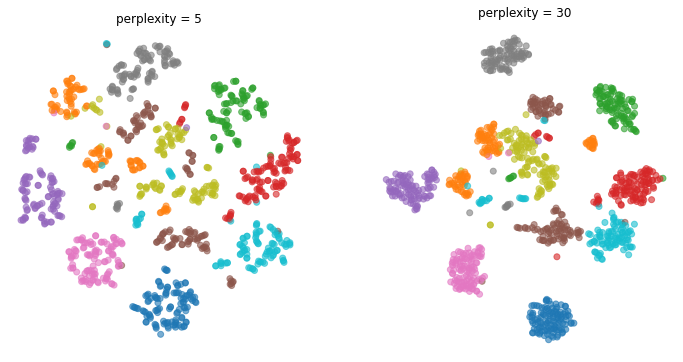

In [47]:
def compare_perplexities(X, perps):
    
    results = []
    for i, perp in enumerate(perps):
        
        print(f"\nStarting training for perplexity value {perp}")
        
        if GPU:
            p_scores = torch.tensor(get_p_scores(X, perp)).cuda()
            y = init_y(X).cuda()
        else:
            p_scores = torch.tensor(get_p_scores(X, perp))
            y = init_y(X)
            
        y.requires_grad_(True)
        results.append((train(p_scores, y).detach().cpu().numpy(), perp))
        
    return results


results = compare_perplexities(X, [5, 30])   
visualize(results, "perplexity")    

We're now ready to load a dataset and try out the our t-SNE implementation. For that, the "handwritten digits"- dataset will we loaded via SKLEARN. Each datapoint is a <b>flattened 8x8</b> array and has an associated class label.

In [7]:
dataset = sklearn.datasets.load_digits()

X = dataset['data']
labels = dataset['target']
R = np.random.mtrand.RandomState(0).permutation(len(X))[:1100]
X = X[R]
labels = labels[R]

The function <i>compare_perplexities</i> takes as input a list of perplexities and for each entry learns a low dimensional embedding using that perplexity for the high dimensional conditional distributions during the training process. 

We use this function to get the results for 2 differing perplexity values and subsequently visualize them for comparison.

In [ ]:
def compare_perplexities(X, perps):
    
    results = []
    for i, perp in enumerate(perps):
        
        print(f"\nStarting training for perplexity value {perp}")
        
        if GPU:
            p_scores = torch.tensor(get_p_scores(X, perp)).cuda()
            y = init_y(X).cuda()
        else:
            p_scores = torch.tensor(get_p_scores(X, perp))
            y = init_y(X)
            
        y.requires_grad_(True)
        results.append((train(p_scores, y).detach().cpu().numpy(), perp))
        
    return results


results = compare_perplexities(X, [5, 30])   
visualize(results, "perplexity")    


Starting training for early exageration factor 1
KL-divergence after 100 iterations: 0.739545010258816
KL-divergence after 200 iterations: 0.6464873284710488
KL-divergence after 300 iterations: 0.6142072401863116
KL-divergence after 400 iterations: 0.577398038996606
KL-divergence after 500 iterations: 0.5644852964827758
KL-divergence after 600 iterations: 0.5567831950291577
KL-divergence after 700 iterations: 0.5520633526853129
KL-divergence after 800 iterations: 0.5496744731844618
KL-divergence after 900 iterations: 0.5475346911816045

Starting training for early exageration factor 12
KL-divergence after 100 iterations: 0.8169037071963706
KL-divergence after 200 iterations: 0.7383468050981631
KL-divergence after 300 iterations: 0.6199391031226165
KL-divergence after 400 iterations: 0.6015404673958566
KL-divergence after 500 iterations: 0.591607204568502
KL-divergence after 600 iterations: 0.5861565454834893
KL-divergence after 700 iterations: 0.5827450249725481
KL-divergence after 80

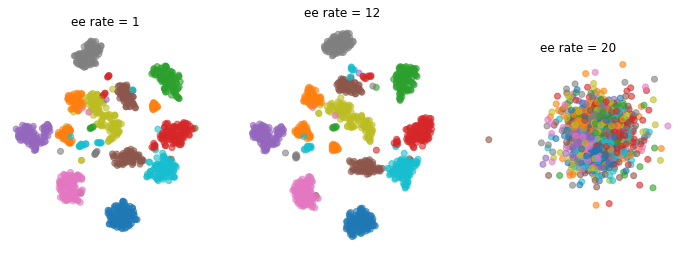

In [42]:
def compare_ee_factors(X, factors):
    
    results = []
    for i, f in enumerate(factors):
        
        print(f"\nStarting training for early exageration factor {f}")
        
        if GPU:
            p_scores = torch.tensor(get_p_scores(X, 30)).cuda()
            y = init_y(X).cuda()
        else:
            p_scores = torch.tensor(get_p_scores(X, 30))
            y = init_y(X)
            
        y.requires_grad_(True)
        results.append((train(p_scores, y, ee_factor = f).detach().cpu().numpy(), f))
        
    return results


results = compare_ee_factors(X, [1, 12, 20])
visualize(results, "ee rate")    

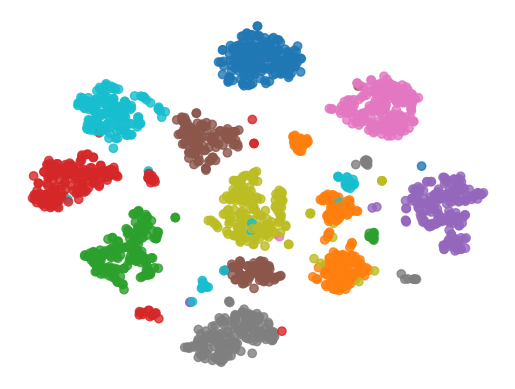

In [55]:
from matplotlib import pyplot as plt

# ax = fig.add_subplot(111)
plt.axis("off")

plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)
# plt.savefig("T-SNE.pdf")

In [15]:
# TODO (Code):
# - demonstrate different hyperparameter choices
# - more datasets? 

In [9]:
from sklearn.manifold import TSNE

model = TSNE(method = "exact",)
embedded = model.fit_transform(X)

/home/manuel/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/manuel/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


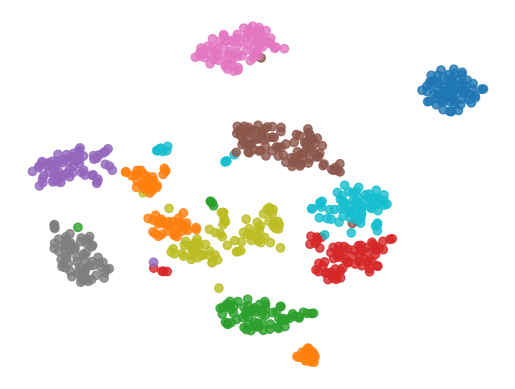

In [10]:
plt.axis("off")

plt.scatter(embedded[:,0], embedded[:,1], c = T, cmap = "tab10", alpha = 0.8)